# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

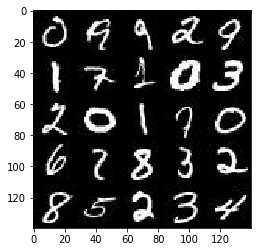

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

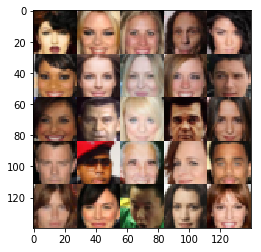

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='input_fake')
    learn_rate = tf.placeholder(tf.float32, name='l_rate')

    return real_input, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [53]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        stddev = 0.02
        # Input layer 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(0.2 * x1, x1)
        
        # Second layer
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        
        # Third layer
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        
        # Fourth layer
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(0.2 * bn4, bn4)
        
        # Flatten
        flat = tf.reshape(relu4, (-1, 2*2*512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        stddev = 0.02
        # Fully connected layer
        x1 = tf.layers.dense(z, (7*7*512))
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(0.2 * bn1, bn1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        
        x4 = tf.layers.conv2d_transpose(relu3, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(0.2 * bn4, bn4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    print_every, show_every, step = 10, 100, 1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                
                if step % print_every == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}.\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}; ".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                
                if step % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2.	 Discriminator Loss: 1.1358;  Generator Loss: 0.6963
Epoch 1/2.	 Discriminator Loss: 1.4767;  Generator Loss: 0.8460
Epoch 1/2.	 Discriminator Loss: 1.5793;  Generator Loss: 0.4906
Epoch 1/2.	 Discriminator Loss: 1.1218;  Generator Loss: 0.9638
Epoch 1/2.	 Discriminator Loss: 0.9588;  Generator Loss: 1.2338
Epoch 1/2.	 Discriminator Loss: 1.0160;  Generator Loss: 1.3822
Epoch 1/2.	 Discriminator Loss: 1.2306;  Generator Loss: 2.6265
Epoch 1/2.	 Discriminator Loss: 1.1178;  Generator Loss: 1.8520
Epoch 1/2.	 Discriminator Loss: 1.8119;  Generator Loss: 0.3035
Epoch 1/2.	 Discriminator Loss: 0.9933;  Generator Loss: 1.5246


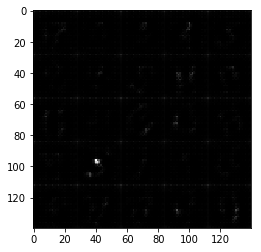

Epoch 1/2.	 Discriminator Loss: 1.0480;  Generator Loss: 1.4504
Epoch 1/2.	 Discriminator Loss: 1.2435;  Generator Loss: 0.6874
Epoch 1/2.	 Discriminator Loss: 1.3185;  Generator Loss: 0.5884
Epoch 1/2.	 Discriminator Loss: 1.0564;  Generator Loss: 1.0953
Epoch 1/2.	 Discriminator Loss: 1.0556;  Generator Loss: 1.7307
Epoch 1/2.	 Discriminator Loss: 1.1587;  Generator Loss: 0.8849
Epoch 1/2.	 Discriminator Loss: 1.2650;  Generator Loss: 0.6953
Epoch 1/2.	 Discriminator Loss: 1.1508;  Generator Loss: 1.0479
Epoch 1/2.	 Discriminator Loss: 1.2350;  Generator Loss: 1.5080
Epoch 1/2.	 Discriminator Loss: 1.2244;  Generator Loss: 1.0420


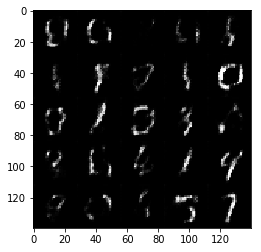

Epoch 1/2.	 Discriminator Loss: 1.1858;  Generator Loss: 0.6921
Epoch 1/2.	 Discriminator Loss: 1.2692;  Generator Loss: 0.7272
Epoch 1/2.	 Discriminator Loss: 0.9907;  Generator Loss: 1.0066
Epoch 1/2.	 Discriminator Loss: 1.1265;  Generator Loss: 1.3574
Epoch 1/2.	 Discriminator Loss: 1.2188;  Generator Loss: 1.6005
Epoch 1/2.	 Discriminator Loss: 1.1415;  Generator Loss: 1.0786
Epoch 1/2.	 Discriminator Loss: 1.3492;  Generator Loss: 1.7632
Epoch 1/2.	 Discriminator Loss: 1.1702;  Generator Loss: 1.1814
Epoch 1/2.	 Discriminator Loss: 1.2344;  Generator Loss: 0.8557
Epoch 1/2.	 Discriminator Loss: 1.1727;  Generator Loss: 1.0089


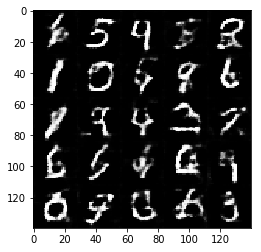

Epoch 1/2.	 Discriminator Loss: 1.6369;  Generator Loss: 0.3998
Epoch 1/2.	 Discriminator Loss: 1.1581;  Generator Loss: 0.7765
Epoch 1/2.	 Discriminator Loss: 1.2242;  Generator Loss: 0.7322
Epoch 1/2.	 Discriminator Loss: 1.4526;  Generator Loss: 1.6858
Epoch 1/2.	 Discriminator Loss: 1.1960;  Generator Loss: 1.2305
Epoch 1/2.	 Discriminator Loss: 1.1602;  Generator Loss: 1.4264
Epoch 1/2.	 Discriminator Loss: 1.1036;  Generator Loss: 1.0730
Epoch 1/2.	 Discriminator Loss: 1.2772;  Generator Loss: 0.6213
Epoch 1/2.	 Discriminator Loss: 1.0410;  Generator Loss: 1.1554
Epoch 1/2.	 Discriminator Loss: 1.0652;  Generator Loss: 1.1997


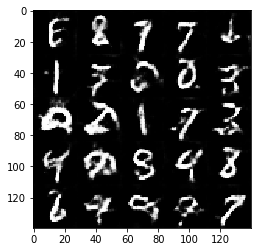

Epoch 1/2.	 Discriminator Loss: 1.0998;  Generator Loss: 1.2817
Epoch 1/2.	 Discriminator Loss: 1.2108;  Generator Loss: 0.8123
Epoch 1/2.	 Discriminator Loss: 1.0951;  Generator Loss: 0.9307
Epoch 1/2.	 Discriminator Loss: 1.2406;  Generator Loss: 0.7469
Epoch 1/2.	 Discriminator Loss: 1.0712;  Generator Loss: 0.8201
Epoch 1/2.	 Discriminator Loss: 1.1897;  Generator Loss: 0.7392
Epoch 2/2.	 Discriminator Loss: 1.2041;  Generator Loss: 0.8614
Epoch 2/2.	 Discriminator Loss: 1.3566;  Generator Loss: 0.5299
Epoch 2/2.	 Discriminator Loss: 1.1740;  Generator Loss: 0.7695
Epoch 2/2.	 Discriminator Loss: 1.3390;  Generator Loss: 1.1976


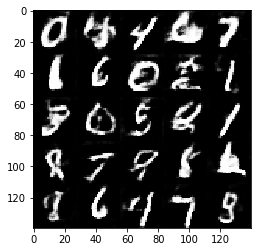

Epoch 2/2.	 Discriminator Loss: 1.1372;  Generator Loss: 0.8389
Epoch 2/2.	 Discriminator Loss: 1.8298;  Generator Loss: 2.3070
Epoch 2/2.	 Discriminator Loss: 1.0701;  Generator Loss: 0.9788
Epoch 2/2.	 Discriminator Loss: 1.0720;  Generator Loss: 1.3457
Epoch 2/2.	 Discriminator Loss: 1.2213;  Generator Loss: 1.2343
Epoch 2/2.	 Discriminator Loss: 1.1718;  Generator Loss: 0.6893
Epoch 2/2.	 Discriminator Loss: 1.4800;  Generator Loss: 1.8543
Epoch 2/2.	 Discriminator Loss: 1.0513;  Generator Loss: 1.1479
Epoch 2/2.	 Discriminator Loss: 1.1325;  Generator Loss: 0.7494
Epoch 2/2.	 Discriminator Loss: 1.4896;  Generator Loss: 0.4328


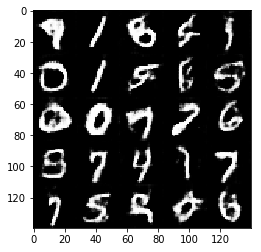

Epoch 2/2.	 Discriminator Loss: 1.7999;  Generator Loss: 2.0676
Epoch 2/2.	 Discriminator Loss: 1.3655;  Generator Loss: 0.5326
Epoch 2/2.	 Discriminator Loss: 2.0350;  Generator Loss: 2.2710
Epoch 2/2.	 Discriminator Loss: 1.1879;  Generator Loss: 0.6967
Epoch 2/2.	 Discriminator Loss: 1.1852;  Generator Loss: 0.6723
Epoch 2/2.	 Discriminator Loss: 1.4087;  Generator Loss: 0.4912
Epoch 2/2.	 Discriminator Loss: 1.4062;  Generator Loss: 0.5936
Epoch 2/2.	 Discriminator Loss: 1.3616;  Generator Loss: 0.6602
Epoch 2/2.	 Discriminator Loss: 1.6051;  Generator Loss: 0.3837
Epoch 2/2.	 Discriminator Loss: 1.0986;  Generator Loss: 0.9778


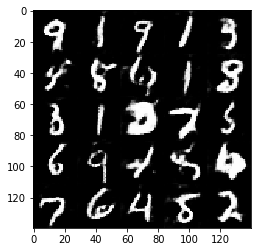

Epoch 2/2.	 Discriminator Loss: 1.5275;  Generator Loss: 0.4384
Epoch 2/2.	 Discriminator Loss: 1.0079;  Generator Loss: 1.2348
Epoch 2/2.	 Discriminator Loss: 1.1943;  Generator Loss: 0.7409
Epoch 2/2.	 Discriminator Loss: 1.2107;  Generator Loss: 0.6908
Epoch 2/2.	 Discriminator Loss: 1.3763;  Generator Loss: 1.2646
Epoch 2/2.	 Discriminator Loss: 1.3186;  Generator Loss: 0.5604
Epoch 2/2.	 Discriminator Loss: 1.1280;  Generator Loss: 1.0946
Epoch 2/2.	 Discriminator Loss: 1.4956;  Generator Loss: 0.4742
Epoch 2/2.	 Discriminator Loss: 1.1461;  Generator Loss: 1.0763
Epoch 2/2.	 Discriminator Loss: 0.9502;  Generator Loss: 1.0747


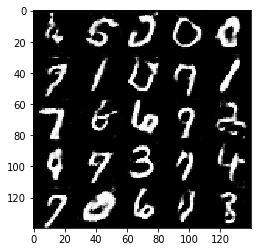

Epoch 2/2.	 Discriminator Loss: 1.0463;  Generator Loss: 0.8105
Epoch 2/2.	 Discriminator Loss: 2.3578;  Generator Loss: 2.7964
Epoch 2/2.	 Discriminator Loss: 1.0463;  Generator Loss: 0.9763
Epoch 2/2.	 Discriminator Loss: 1.1304;  Generator Loss: 0.7727
Epoch 2/2.	 Discriminator Loss: 1.0049;  Generator Loss: 0.9113
Epoch 2/2.	 Discriminator Loss: 0.9559;  Generator Loss: 1.1139
Epoch 2/2.	 Discriminator Loss: 1.1458;  Generator Loss: 0.8260
Epoch 2/2.	 Discriminator Loss: 1.1572;  Generator Loss: 1.1116
Epoch 2/2.	 Discriminator Loss: 1.0669;  Generator Loss: 1.4198
Epoch 2/2.	 Discriminator Loss: 1.2692;  Generator Loss: 0.8257


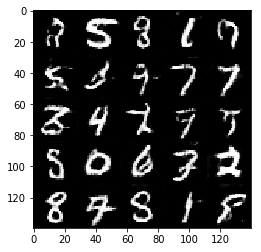

Epoch 2/2.	 Discriminator Loss: 0.9208;  Generator Loss: 1.2728
Epoch 2/2.	 Discriminator Loss: 1.1611;  Generator Loss: 1.2305
Epoch 2/2.	 Discriminator Loss: 0.9417;  Generator Loss: 1.2540


In [55]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1.	 Discriminator Loss: 1.0927;  Generator Loss: 1.3170
Epoch 1/1.	 Discriminator Loss: 1.1392;  Generator Loss: 5.8903
Epoch 1/1.	 Discriminator Loss: 0.9835;  Generator Loss: 1.3487
Epoch 1/1.	 Discriminator Loss: 1.1572;  Generator Loss: 1.8759
Epoch 1/1.	 Discriminator Loss: 0.9812;  Generator Loss: 2.8391
Epoch 1/1.	 Discriminator Loss: 0.8319;  Generator Loss: 1.2630
Epoch 1/1.	 Discriminator Loss: 1.7334;  Generator Loss: 5.8117
Epoch 1/1.	 Discriminator Loss: 1.8411;  Generator Loss: 0.3688
Epoch 1/1.	 Discriminator Loss: 1.2196;  Generator Loss: 0.6378
Epoch 1/1.	 Discriminator Loss: 0.7731;  Generator Loss: 2.0906


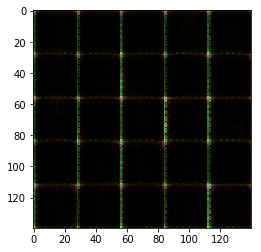

Epoch 1/1.	 Discriminator Loss: 0.9752;  Generator Loss: 0.9687
Epoch 1/1.	 Discriminator Loss: 1.3536;  Generator Loss: 0.5998
Epoch 1/1.	 Discriminator Loss: 1.1326;  Generator Loss: 0.7509
Epoch 1/1.	 Discriminator Loss: 1.2427;  Generator Loss: 1.6455
Epoch 1/1.	 Discriminator Loss: 1.1286;  Generator Loss: 1.8083
Epoch 1/1.	 Discriminator Loss: 1.4661;  Generator Loss: 2.3105
Epoch 1/1.	 Discriminator Loss: 1.4576;  Generator Loss: 0.6178
Epoch 1/1.	 Discriminator Loss: 1.7772;  Generator Loss: 0.3768
Epoch 1/1.	 Discriminator Loss: 1.8039;  Generator Loss: 0.4186
Epoch 1/1.	 Discriminator Loss: 1.3411;  Generator Loss: 2.2516


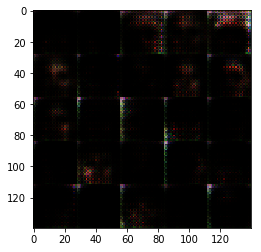

Epoch 1/1.	 Discriminator Loss: 1.1893;  Generator Loss: 0.8711
Epoch 1/1.	 Discriminator Loss: 1.2059;  Generator Loss: 1.0392
Epoch 1/1.	 Discriminator Loss: 0.8937;  Generator Loss: 1.4821
Epoch 1/1.	 Discriminator Loss: 1.0215;  Generator Loss: 1.1635
Epoch 1/1.	 Discriminator Loss: 1.4136;  Generator Loss: 2.1775
Epoch 1/1.	 Discriminator Loss: 1.2036;  Generator Loss: 1.2658
Epoch 1/1.	 Discriminator Loss: 1.0021;  Generator Loss: 1.6336
Epoch 1/1.	 Discriminator Loss: 1.2535;  Generator Loss: 0.8028
Epoch 1/1.	 Discriminator Loss: 1.8411;  Generator Loss: 0.3175
Epoch 1/1.	 Discriminator Loss: 1.0770;  Generator Loss: 1.1091


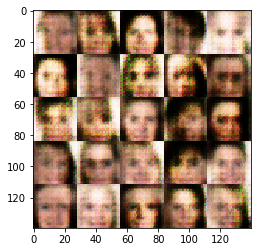

Epoch 1/1.	 Discriminator Loss: 1.1901;  Generator Loss: 1.0321
Epoch 1/1.	 Discriminator Loss: 1.0059;  Generator Loss: 1.1064
Epoch 1/1.	 Discriminator Loss: 1.0824;  Generator Loss: 0.8478
Epoch 1/1.	 Discriminator Loss: 1.3606;  Generator Loss: 0.9201
Epoch 1/1.	 Discriminator Loss: 1.9004;  Generator Loss: 0.3100
Epoch 1/1.	 Discriminator Loss: 1.1819;  Generator Loss: 0.9421
Epoch 1/1.	 Discriminator Loss: 1.3792;  Generator Loss: 0.6537
Epoch 1/1.	 Discriminator Loss: 1.8596;  Generator Loss: 2.5326
Epoch 1/1.	 Discriminator Loss: 1.7171;  Generator Loss: 0.3791
Epoch 1/1.	 Discriminator Loss: 0.9242;  Generator Loss: 1.2881


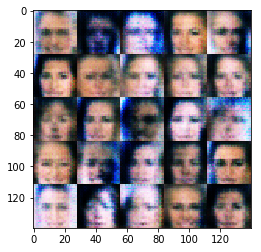

Epoch 1/1.	 Discriminator Loss: 1.3886;  Generator Loss: 2.8698
Epoch 1/1.	 Discriminator Loss: 1.0263;  Generator Loss: 0.8438
Epoch 1/1.	 Discriminator Loss: 0.9117;  Generator Loss: 1.1796
Epoch 1/1.	 Discriminator Loss: 1.2753;  Generator Loss: 0.9021
Epoch 1/1.	 Discriminator Loss: 1.0612;  Generator Loss: 1.1861
Epoch 1/1.	 Discriminator Loss: 1.3422;  Generator Loss: 0.7103
Epoch 1/1.	 Discriminator Loss: 1.1174;  Generator Loss: 1.1024
Epoch 1/1.	 Discriminator Loss: 1.4267;  Generator Loss: 0.7423
Epoch 1/1.	 Discriminator Loss: 1.0993;  Generator Loss: 1.0824
Epoch 1/1.	 Discriminator Loss: 1.0279;  Generator Loss: 1.7121


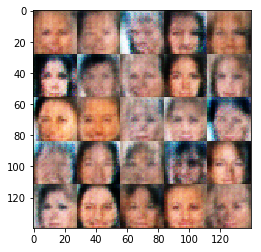

Epoch 1/1.	 Discriminator Loss: 1.0154;  Generator Loss: 0.9985
Epoch 1/1.	 Discriminator Loss: 1.0705;  Generator Loss: 1.4017
Epoch 1/1.	 Discriminator Loss: 1.2751;  Generator Loss: 0.8254
Epoch 1/1.	 Discriminator Loss: 1.0494;  Generator Loss: 1.0347
Epoch 1/1.	 Discriminator Loss: 1.3699;  Generator Loss: 0.7646
Epoch 1/1.	 Discriminator Loss: 1.1345;  Generator Loss: 0.8766
Epoch 1/1.	 Discriminator Loss: 1.1683;  Generator Loss: 1.1485
Epoch 1/1.	 Discriminator Loss: 1.1093;  Generator Loss: 1.2234
Epoch 1/1.	 Discriminator Loss: 1.5490;  Generator Loss: 0.6156
Epoch 1/1.	 Discriminator Loss: 1.2582;  Generator Loss: 0.7024


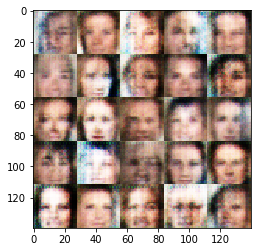

Epoch 1/1.	 Discriminator Loss: 1.3716;  Generator Loss: 0.6031
Epoch 1/1.	 Discriminator Loss: 1.2394;  Generator Loss: 0.8873
Epoch 1/1.	 Discriminator Loss: 1.2892;  Generator Loss: 0.9651
Epoch 1/1.	 Discriminator Loss: 1.1677;  Generator Loss: 0.7605
Epoch 1/1.	 Discriminator Loss: 1.2972;  Generator Loss: 0.6698
Epoch 1/1.	 Discriminator Loss: 1.2825;  Generator Loss: 0.7457
Epoch 1/1.	 Discriminator Loss: 1.6048;  Generator Loss: 1.7677
Epoch 1/1.	 Discriminator Loss: 1.3448;  Generator Loss: 0.7230
Epoch 1/1.	 Discriminator Loss: 1.3535;  Generator Loss: 0.7410
Epoch 1/1.	 Discriminator Loss: 1.1165;  Generator Loss: 0.8935


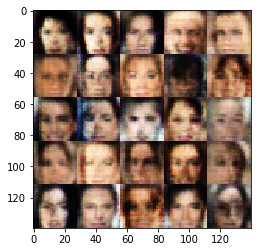

Epoch 1/1.	 Discriminator Loss: 1.2184;  Generator Loss: 1.0052
Epoch 1/1.	 Discriminator Loss: 1.1445;  Generator Loss: 0.8682
Epoch 1/1.	 Discriminator Loss: 1.1019;  Generator Loss: 1.1189
Epoch 1/1.	 Discriminator Loss: 1.1412;  Generator Loss: 0.9705
Epoch 1/1.	 Discriminator Loss: 1.2858;  Generator Loss: 1.0921
Epoch 1/1.	 Discriminator Loss: 1.1300;  Generator Loss: 0.8716
Epoch 1/1.	 Discriminator Loss: 1.1302;  Generator Loss: 0.8291
Epoch 1/1.	 Discriminator Loss: 1.1260;  Generator Loss: 0.8629
Epoch 1/1.	 Discriminator Loss: 1.1952;  Generator Loss: 0.8771
Epoch 1/1.	 Discriminator Loss: 1.0849;  Generator Loss: 1.1114


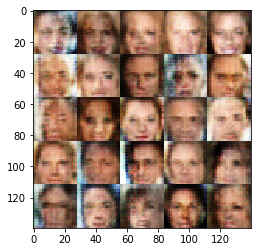

Epoch 1/1.	 Discriminator Loss: 1.0667;  Generator Loss: 1.2931
Epoch 1/1.	 Discriminator Loss: 1.0625;  Generator Loss: 0.8678
Epoch 1/1.	 Discriminator Loss: 1.1902;  Generator Loss: 0.8942
Epoch 1/1.	 Discriminator Loss: 1.1610;  Generator Loss: 0.9264
Epoch 1/1.	 Discriminator Loss: 1.3026;  Generator Loss: 0.8605
Epoch 1/1.	 Discriminator Loss: 1.5401;  Generator Loss: 0.4683
Epoch 1/1.	 Discriminator Loss: 1.2418;  Generator Loss: 0.9274
Epoch 1/1.	 Discriminator Loss: 1.4637;  Generator Loss: 0.4907
Epoch 1/1.	 Discriminator Loss: 1.2558;  Generator Loss: 0.7976
Epoch 1/1.	 Discriminator Loss: 1.2446;  Generator Loss: 1.0065


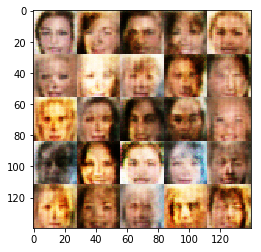

Epoch 1/1.	 Discriminator Loss: 1.1211;  Generator Loss: 0.9921
Epoch 1/1.	 Discriminator Loss: 1.0401;  Generator Loss: 1.5025
Epoch 1/1.	 Discriminator Loss: 1.0766;  Generator Loss: 0.8348
Epoch 1/1.	 Discriminator Loss: 1.4681;  Generator Loss: 0.6460
Epoch 1/1.	 Discriminator Loss: 1.3536;  Generator Loss: 1.5054
Epoch 1/1.	 Discriminator Loss: 1.1048;  Generator Loss: 0.9295
Epoch 1/1.	 Discriminator Loss: 1.0842;  Generator Loss: 0.9527
Epoch 1/1.	 Discriminator Loss: 1.2190;  Generator Loss: 0.8615
Epoch 1/1.	 Discriminator Loss: 1.1230;  Generator Loss: 0.8560
Epoch 1/1.	 Discriminator Loss: 1.1192;  Generator Loss: 0.8793


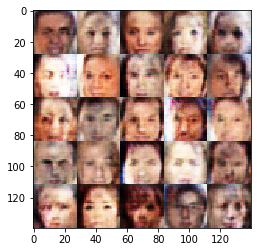

Epoch 1/1.	 Discriminator Loss: 1.2381;  Generator Loss: 0.6973
Epoch 1/1.	 Discriminator Loss: 1.1109;  Generator Loss: 1.0135
Epoch 1/1.	 Discriminator Loss: 1.1762;  Generator Loss: 0.8124
Epoch 1/1.	 Discriminator Loss: 1.3229;  Generator Loss: 1.0369
Epoch 1/1.	 Discriminator Loss: 1.2750;  Generator Loss: 0.9057
Epoch 1/1.	 Discriminator Loss: 1.3373;  Generator Loss: 0.9510
Epoch 1/1.	 Discriminator Loss: 1.1508;  Generator Loss: 0.8907
Epoch 1/1.	 Discriminator Loss: 1.4173;  Generator Loss: 0.5386
Epoch 1/1.	 Discriminator Loss: 1.0316;  Generator Loss: 1.0736
Epoch 1/1.	 Discriminator Loss: 1.1275;  Generator Loss: 0.7566


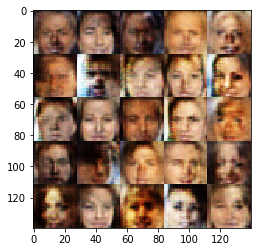

Epoch 1/1.	 Discriminator Loss: 0.9932;  Generator Loss: 1.3167
Epoch 1/1.	 Discriminator Loss: 1.0285;  Generator Loss: 1.2282
Epoch 1/1.	 Discriminator Loss: 1.0957;  Generator Loss: 0.9828
Epoch 1/1.	 Discriminator Loss: 1.1858;  Generator Loss: 0.7960
Epoch 1/1.	 Discriminator Loss: 1.1717;  Generator Loss: 1.0488
Epoch 1/1.	 Discriminator Loss: 0.9785;  Generator Loss: 1.4600
Epoch 1/1.	 Discriminator Loss: 1.2913;  Generator Loss: 0.7586
Epoch 1/1.	 Discriminator Loss: 1.2280;  Generator Loss: 0.6971
Epoch 1/1.	 Discriminator Loss: 1.0420;  Generator Loss: 1.5897
Epoch 1/1.	 Discriminator Loss: 1.3370;  Generator Loss: 0.9569


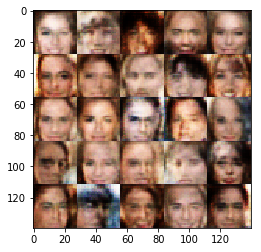

Epoch 1/1.	 Discriminator Loss: 1.0681;  Generator Loss: 1.1563
Epoch 1/1.	 Discriminator Loss: 1.2473;  Generator Loss: 0.7353
Epoch 1/1.	 Discriminator Loss: 1.1084;  Generator Loss: 1.3347
Epoch 1/1.	 Discriminator Loss: 1.1223;  Generator Loss: 1.0095
Epoch 1/1.	 Discriminator Loss: 1.2446;  Generator Loss: 0.7563
Epoch 1/1.	 Discriminator Loss: 1.1793;  Generator Loss: 0.7989
Epoch 1/1.	 Discriminator Loss: 1.1363;  Generator Loss: 0.9987
Epoch 1/1.	 Discriminator Loss: 1.3388;  Generator Loss: 0.5814
Epoch 1/1.	 Discriminator Loss: 1.2114;  Generator Loss: 0.7164
Epoch 1/1.	 Discriminator Loss: 1.0162;  Generator Loss: 0.9839


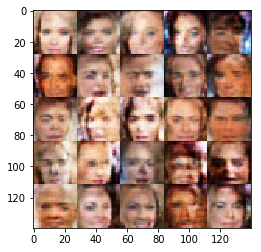

Epoch 1/1.	 Discriminator Loss: 1.2433;  Generator Loss: 0.7580
Epoch 1/1.	 Discriminator Loss: 1.1532;  Generator Loss: 0.9874
Epoch 1/1.	 Discriminator Loss: 1.3593;  Generator Loss: 0.6404
Epoch 1/1.	 Discriminator Loss: 1.4199;  Generator Loss: 0.5581
Epoch 1/1.	 Discriminator Loss: 0.9490;  Generator Loss: 1.1278
Epoch 1/1.	 Discriminator Loss: 1.0807;  Generator Loss: 0.9976
Epoch 1/1.	 Discriminator Loss: 1.1608;  Generator Loss: 0.8485
Epoch 1/1.	 Discriminator Loss: 1.0652;  Generator Loss: 1.1170
Epoch 1/1.	 Discriminator Loss: 1.2090;  Generator Loss: 0.9881
Epoch 1/1.	 Discriminator Loss: 1.1161;  Generator Loss: 1.0730


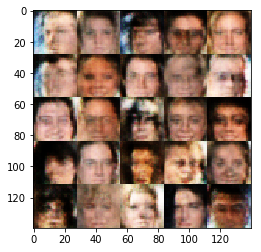

Epoch 1/1.	 Discriminator Loss: 1.0011;  Generator Loss: 1.2033
Epoch 1/1.	 Discriminator Loss: 1.3357;  Generator Loss: 0.5410
Epoch 1/1.	 Discriminator Loss: 1.1174;  Generator Loss: 1.0375
Epoch 1/1.	 Discriminator Loss: 1.1154;  Generator Loss: 0.8532
Epoch 1/1.	 Discriminator Loss: 1.2331;  Generator Loss: 0.7804
Epoch 1/1.	 Discriminator Loss: 1.1630;  Generator Loss: 0.7195
Epoch 1/1.	 Discriminator Loss: 1.2526;  Generator Loss: 0.6580
Epoch 1/1.	 Discriminator Loss: 1.2644;  Generator Loss: 0.6089
Epoch 1/1.	 Discriminator Loss: 1.1731;  Generator Loss: 0.7932
Epoch 1/1.	 Discriminator Loss: 1.1457;  Generator Loss: 0.8584


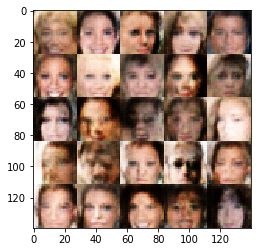

Epoch 1/1.	 Discriminator Loss: 1.5735;  Generator Loss: 0.3910
Epoch 1/1.	 Discriminator Loss: 0.9753;  Generator Loss: 1.3476
Epoch 1/1.	 Discriminator Loss: 1.2377;  Generator Loss: 0.7171
Epoch 1/1.	 Discriminator Loss: 1.0987;  Generator Loss: 0.7805
Epoch 1/1.	 Discriminator Loss: 1.4015;  Generator Loss: 0.5169
Epoch 1/1.	 Discriminator Loss: 1.1958;  Generator Loss: 0.7855
Epoch 1/1.	 Discriminator Loss: 1.1048;  Generator Loss: 0.8878
Epoch 1/1.	 Discriminator Loss: 1.0658;  Generator Loss: 1.6596
Epoch 1/1.	 Discriminator Loss: 1.1934;  Generator Loss: 0.8096
Epoch 1/1.	 Discriminator Loss: 1.1888;  Generator Loss: 1.0218


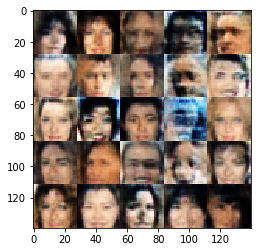

Epoch 1/1.	 Discriminator Loss: 1.2255;  Generator Loss: 0.8494
Epoch 1/1.	 Discriminator Loss: 1.1833;  Generator Loss: 0.8474
Epoch 1/1.	 Discriminator Loss: 1.1745;  Generator Loss: 1.5538
Epoch 1/1.	 Discriminator Loss: 1.1417;  Generator Loss: 0.9896
Epoch 1/1.	 Discriminator Loss: 0.9994;  Generator Loss: 1.6467
Epoch 1/1.	 Discriminator Loss: 1.1433;  Generator Loss: 0.8185
Epoch 1/1.	 Discriminator Loss: 0.8707;  Generator Loss: 1.2635
Epoch 1/1.	 Discriminator Loss: 1.0967;  Generator Loss: 0.9473
Epoch 1/1.	 Discriminator Loss: 1.0277;  Generator Loss: 0.9269
Epoch 1/1.	 Discriminator Loss: 1.0426;  Generator Loss: 1.0029


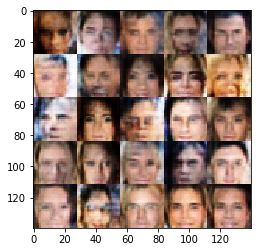

Epoch 1/1.	 Discriminator Loss: 1.2186;  Generator Loss: 1.2304
Epoch 1/1.	 Discriminator Loss: 0.9241;  Generator Loss: 1.1340
Epoch 1/1.	 Discriminator Loss: 0.9140;  Generator Loss: 1.1205
Epoch 1/1.	 Discriminator Loss: 1.1378;  Generator Loss: 1.1345
Epoch 1/1.	 Discriminator Loss: 1.0767;  Generator Loss: 1.0814
Epoch 1/1.	 Discriminator Loss: 1.0174;  Generator Loss: 1.0537
Epoch 1/1.	 Discriminator Loss: 1.1139;  Generator Loss: 1.1832
Epoch 1/1.	 Discriminator Loss: 1.0482;  Generator Loss: 1.3654
Epoch 1/1.	 Discriminator Loss: 1.1277;  Generator Loss: 0.8865
Epoch 1/1.	 Discriminator Loss: 1.0177;  Generator Loss: 1.0794


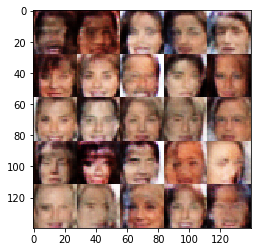

Epoch 1/1.	 Discriminator Loss: 1.1523;  Generator Loss: 0.9845
Epoch 1/1.	 Discriminator Loss: 1.4089;  Generator Loss: 0.5224
Epoch 1/1.	 Discriminator Loss: 1.3498;  Generator Loss: 0.5587
Epoch 1/1.	 Discriminator Loss: 1.1448;  Generator Loss: 1.0543
Epoch 1/1.	 Discriminator Loss: 1.1191;  Generator Loss: 0.7906
Epoch 1/1.	 Discriminator Loss: 1.2172;  Generator Loss: 0.7988
Epoch 1/1.	 Discriminator Loss: 1.3485;  Generator Loss: 0.5585
Epoch 1/1.	 Discriminator Loss: 0.9928;  Generator Loss: 1.1616
Epoch 1/1.	 Discriminator Loss: 0.9659;  Generator Loss: 1.0796
Epoch 1/1.	 Discriminator Loss: 1.0199;  Generator Loss: 0.9453


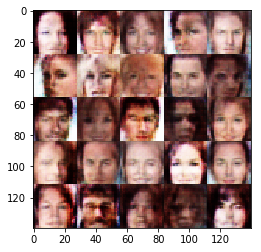

Epoch 1/1.	 Discriminator Loss: 1.0748;  Generator Loss: 1.0627
Epoch 1/1.	 Discriminator Loss: 1.1759;  Generator Loss: 0.7927
Epoch 1/1.	 Discriminator Loss: 1.0336;  Generator Loss: 0.9383
Epoch 1/1.	 Discriminator Loss: 1.2483;  Generator Loss: 0.6237
Epoch 1/1.	 Discriminator Loss: 1.0548;  Generator Loss: 1.1310
Epoch 1/1.	 Discriminator Loss: 1.4263;  Generator Loss: 0.5094
Epoch 1/1.	 Discriminator Loss: 0.9944;  Generator Loss: 0.9338
Epoch 1/1.	 Discriminator Loss: 1.1959;  Generator Loss: 0.9268
Epoch 1/1.	 Discriminator Loss: 0.9028;  Generator Loss: 1.5839
Epoch 1/1.	 Discriminator Loss: 1.2527;  Generator Loss: 0.6497


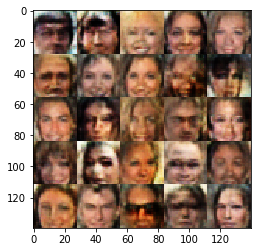

Epoch 1/1.	 Discriminator Loss: 1.1299;  Generator Loss: 0.8935
Epoch 1/1.	 Discriminator Loss: 1.0121;  Generator Loss: 0.9966
Epoch 1/1.	 Discriminator Loss: 1.0249;  Generator Loss: 1.3382
Epoch 1/1.	 Discriminator Loss: 1.5072;  Generator Loss: 0.4430
Epoch 1/1.	 Discriminator Loss: 1.2811;  Generator Loss: 0.6148
Epoch 1/1.	 Discriminator Loss: 1.3704;  Generator Loss: 0.5512
Epoch 1/1.	 Discriminator Loss: 1.0152;  Generator Loss: 1.0425
Epoch 1/1.	 Discriminator Loss: 1.2165;  Generator Loss: 0.8876
Epoch 1/1.	 Discriminator Loss: 1.0924;  Generator Loss: 1.1619
Epoch 1/1.	 Discriminator Loss: 1.3610;  Generator Loss: 0.5834


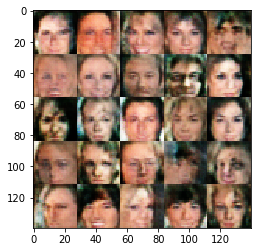

Epoch 1/1.	 Discriminator Loss: 1.0902;  Generator Loss: 0.8482
Epoch 1/1.	 Discriminator Loss: 1.1038;  Generator Loss: 0.9837
Epoch 1/1.	 Discriminator Loss: 1.1626;  Generator Loss: 0.8282
Epoch 1/1.	 Discriminator Loss: 1.0883;  Generator Loss: 0.8331
Epoch 1/1.	 Discriminator Loss: 1.0897;  Generator Loss: 0.9379
Epoch 1/1.	 Discriminator Loss: 1.1808;  Generator Loss: 0.8035
Epoch 1/1.	 Discriminator Loss: 1.0214;  Generator Loss: 1.3603
Epoch 1/1.	 Discriminator Loss: 1.4824;  Generator Loss: 2.3412
Epoch 1/1.	 Discriminator Loss: 1.3284;  Generator Loss: 0.5431
Epoch 1/1.	 Discriminator Loss: 1.5753;  Generator Loss: 0.4442


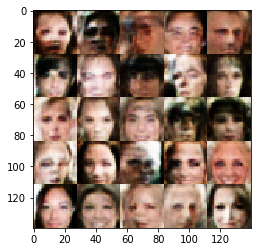

Epoch 1/1.	 Discriminator Loss: 1.0216;  Generator Loss: 0.9925
Epoch 1/1.	 Discriminator Loss: 1.1359;  Generator Loss: 0.8343
Epoch 1/1.	 Discriminator Loss: 1.0529;  Generator Loss: 0.9453
Epoch 1/1.	 Discriminator Loss: 1.3004;  Generator Loss: 0.5856
Epoch 1/1.	 Discriminator Loss: 1.1586;  Generator Loss: 0.6715
Epoch 1/1.	 Discriminator Loss: 1.3875;  Generator Loss: 0.5068
Epoch 1/1.	 Discriminator Loss: 0.8981;  Generator Loss: 1.0760
Epoch 1/1.	 Discriminator Loss: 1.3200;  Generator Loss: 0.6342
Epoch 1/1.	 Discriminator Loss: 1.4389;  Generator Loss: 0.5174
Epoch 1/1.	 Discriminator Loss: 1.2254;  Generator Loss: 0.7232


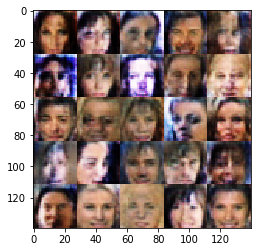

Epoch 1/1.	 Discriminator Loss: 1.3669;  Generator Loss: 0.6733
Epoch 1/1.	 Discriminator Loss: 1.1504;  Generator Loss: 1.1950
Epoch 1/1.	 Discriminator Loss: 0.9796;  Generator Loss: 1.4207
Epoch 1/1.	 Discriminator Loss: 1.1634;  Generator Loss: 0.8075
Epoch 1/1.	 Discriminator Loss: 1.1752;  Generator Loss: 0.8993
Epoch 1/1.	 Discriminator Loss: 1.3594;  Generator Loss: 0.6506
Epoch 1/1.	 Discriminator Loss: 1.2646;  Generator Loss: 1.3549
Epoch 1/1.	 Discriminator Loss: 0.9108;  Generator Loss: 1.2026
Epoch 1/1.	 Discriminator Loss: 1.2327;  Generator Loss: 0.6967
Epoch 1/1.	 Discriminator Loss: 1.1791;  Generator Loss: 0.7629


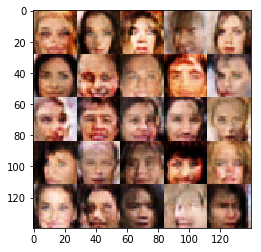

Epoch 1/1.	 Discriminator Loss: 1.1827;  Generator Loss: 0.7526
Epoch 1/1.	 Discriminator Loss: 1.0694;  Generator Loss: 1.5658
Epoch 1/1.	 Discriminator Loss: 1.0175;  Generator Loss: 1.0312
Epoch 1/1.	 Discriminator Loss: 1.0386;  Generator Loss: 0.9080
Epoch 1/1.	 Discriminator Loss: 1.1402;  Generator Loss: 0.7650
Epoch 1/1.	 Discriminator Loss: 1.1629;  Generator Loss: 1.2542
Epoch 1/1.	 Discriminator Loss: 1.0221;  Generator Loss: 1.0026
Epoch 1/1.	 Discriminator Loss: 1.3200;  Generator Loss: 0.7659
Epoch 1/1.	 Discriminator Loss: 1.0427;  Generator Loss: 0.9876
Epoch 1/1.	 Discriminator Loss: 1.1742;  Generator Loss: 1.0280


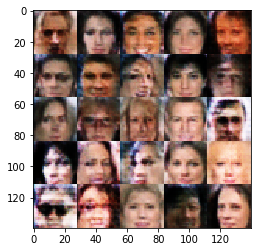

Epoch 1/1.	 Discriminator Loss: 1.1307;  Generator Loss: 0.9871
Epoch 1/1.	 Discriminator Loss: 1.1108;  Generator Loss: 0.9243
Epoch 1/1.	 Discriminator Loss: 1.5461;  Generator Loss: 0.4289
Epoch 1/1.	 Discriminator Loss: 1.3091;  Generator Loss: 0.7938
Epoch 1/1.	 Discriminator Loss: 1.1579;  Generator Loss: 1.0069
Epoch 1/1.	 Discriminator Loss: 1.0917;  Generator Loss: 0.8726
Epoch 1/1.	 Discriminator Loss: 1.0752;  Generator Loss: 1.0480
Epoch 1/1.	 Discriminator Loss: 1.1020;  Generator Loss: 0.8432
Epoch 1/1.	 Discriminator Loss: 1.1333;  Generator Loss: 0.9957
Epoch 1/1.	 Discriminator Loss: 1.2545;  Generator Loss: 0.6044


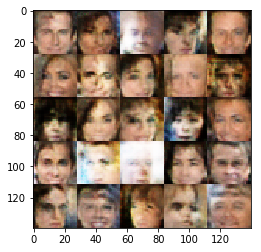

Epoch 1/1.	 Discriminator Loss: 0.8703;  Generator Loss: 1.1131
Epoch 1/1.	 Discriminator Loss: 1.1179;  Generator Loss: 0.9766
Epoch 1/1.	 Discriminator Loss: 1.1932;  Generator Loss: 0.7285
Epoch 1/1.	 Discriminator Loss: 1.3311;  Generator Loss: 0.5586
Epoch 1/1.	 Discriminator Loss: 0.9387;  Generator Loss: 1.1984
Epoch 1/1.	 Discriminator Loss: 1.2121;  Generator Loss: 1.1831
Epoch 1/1.	 Discriminator Loss: 1.2851;  Generator Loss: 1.0413
Epoch 1/1.	 Discriminator Loss: 1.2718;  Generator Loss: 0.6156
Epoch 1/1.	 Discriminator Loss: 1.1772;  Generator Loss: 0.7723
Epoch 1/1.	 Discriminator Loss: 1.0997;  Generator Loss: 0.8505


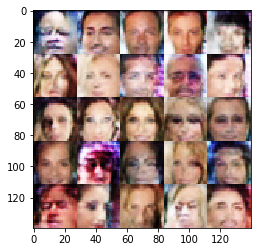

Epoch 1/1.	 Discriminator Loss: 0.9483;  Generator Loss: 1.3124
Epoch 1/1.	 Discriminator Loss: 1.5237;  Generator Loss: 0.4055
Epoch 1/1.	 Discriminator Loss: 1.1100;  Generator Loss: 1.0516
Epoch 1/1.	 Discriminator Loss: 1.0622;  Generator Loss: 1.0888
Epoch 1/1.	 Discriminator Loss: 1.0822;  Generator Loss: 1.2013
Epoch 1/1.	 Discriminator Loss: 1.5515;  Generator Loss: 0.4766
Epoch 1/1.	 Discriminator Loss: 1.7894;  Generator Loss: 0.3270
Epoch 1/1.	 Discriminator Loss: 1.2532;  Generator Loss: 0.8924
Epoch 1/1.	 Discriminator Loss: 1.3244;  Generator Loss: 0.6844
Epoch 1/1.	 Discriminator Loss: 0.9528;  Generator Loss: 1.1925


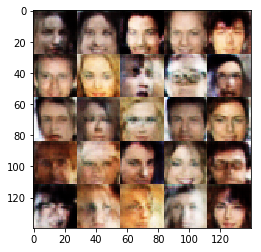

Epoch 1/1.	 Discriminator Loss: 1.1315;  Generator Loss: 0.8338
Epoch 1/1.	 Discriminator Loss: 1.0584;  Generator Loss: 0.9371
Epoch 1/1.	 Discriminator Loss: 1.0496;  Generator Loss: 1.2211
Epoch 1/1.	 Discriminator Loss: 1.3092;  Generator Loss: 0.5280
Epoch 1/1.	 Discriminator Loss: 1.0837;  Generator Loss: 1.0659
Epoch 1/1.	 Discriminator Loss: 1.1656;  Generator Loss: 1.1131
Epoch 1/1.	 Discriminator Loss: 1.2561;  Generator Loss: 0.5861
Epoch 1/1.	 Discriminator Loss: 1.0219;  Generator Loss: 0.9402
Epoch 1/1.	 Discriminator Loss: 1.2903;  Generator Loss: 0.9478
Epoch 1/1.	 Discriminator Loss: 0.9273;  Generator Loss: 1.1022


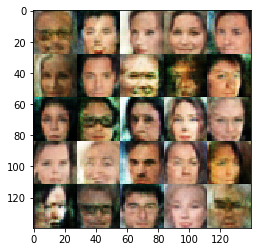

Epoch 1/1.	 Discriminator Loss: 0.8532;  Generator Loss: 1.3541
Epoch 1/1.	 Discriminator Loss: 1.1496;  Generator Loss: 0.7761
Epoch 1/1.	 Discriminator Loss: 1.0360;  Generator Loss: 1.0087
Epoch 1/1.	 Discriminator Loss: 1.3736;  Generator Loss: 0.7198
Epoch 1/1.	 Discriminator Loss: 1.3526;  Generator Loss: 0.5548
Epoch 1/1.	 Discriminator Loss: 0.9777;  Generator Loss: 1.0921
Epoch 1/1.	 Discriminator Loss: 1.4761;  Generator Loss: 0.5056
Epoch 1/1.	 Discriminator Loss: 1.3002;  Generator Loss: 0.6840
Epoch 1/1.	 Discriminator Loss: 1.0665;  Generator Loss: 1.1822
Epoch 1/1.	 Discriminator Loss: 1.1264;  Generator Loss: 0.7811


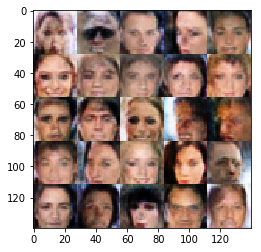

Epoch 1/1.	 Discriminator Loss: 1.0622;  Generator Loss: 0.8450
Epoch 1/1.	 Discriminator Loss: 1.0431;  Generator Loss: 1.1590
Epoch 1/1.	 Discriminator Loss: 0.8703;  Generator Loss: 1.3419
Epoch 1/1.	 Discriminator Loss: 1.3956;  Generator Loss: 0.5092
Epoch 1/1.	 Discriminator Loss: 1.0737;  Generator Loss: 1.0444
Epoch 1/1.	 Discriminator Loss: 0.9083;  Generator Loss: 1.1288
Epoch 1/1.	 Discriminator Loss: 1.2797;  Generator Loss: 0.7564
Epoch 1/1.	 Discriminator Loss: 1.2154;  Generator Loss: 0.6976
Epoch 1/1.	 Discriminator Loss: 1.2480;  Generator Loss: 0.8222
Epoch 1/1.	 Discriminator Loss: 1.2303;  Generator Loss: 0.6586


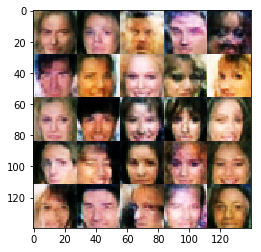

Epoch 1/1.	 Discriminator Loss: 1.1697;  Generator Loss: 0.8941
Epoch 1/1.	 Discriminator Loss: 1.3274;  Generator Loss: 0.5767
Epoch 1/1.	 Discriminator Loss: 1.1600;  Generator Loss: 0.7623
Epoch 1/1.	 Discriminator Loss: 1.0182;  Generator Loss: 0.9637
Epoch 1/1.	 Discriminator Loss: 1.1487;  Generator Loss: 0.7514
Epoch 1/1.	 Discriminator Loss: 1.0948;  Generator Loss: 1.2917


In [56]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.